In [1]:
%matplotlib nbagg
import numpy as np
import json
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm, threshold
import glob

### Next cell: list files of a scan

In [2]:
#scan_name ="RuBpy_XAS_scan_3"
scan_name ="MB_monoscan_11"
DIR_json = "/sf/alvra/data/p18442/res/scan_info/"
DIR = "/sf/alvra/data/p18442/raw/scan_data/" + scan_name + "/"             #use this for a scan

#######################################################################

files_scan = glob.glob(DIR_json + scan_name + '.*')
print (files_scan)
scan_range = '.'+files_scan[-1].split('.')[-2]
print (scan_range)

!ls -lah -rt $DIR | grep BSREAD.h5
!hostname


['/sf/alvra/data/p18442/res/scan_info/MB_monoscan_11.run002952-002997.json']
.run002952-002997
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:24 run_002952.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:26 run_002953.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:28 run_002954.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:30 run_002955.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:32 run_002956.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:33 run_002957.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:35 run_002958.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:37 run_002959.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:39 run_002960.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:41 run_002961.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:43 run_002962.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:45 run_002963.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  2 21:46 run_002964.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G F

# Load one step and check I0 filtering

### First plot pump/unpump to see if channels are all right


--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 9999 / 9999 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Loaded pump = (2499,) and unpump = (2499,) shots
Energy = 2476.504032651242 eV
Median value Izero (all) = 0.2084393035620451
Median value fluo (all) = 0.03009939665841585


<IPython.core.display.Javascript object>


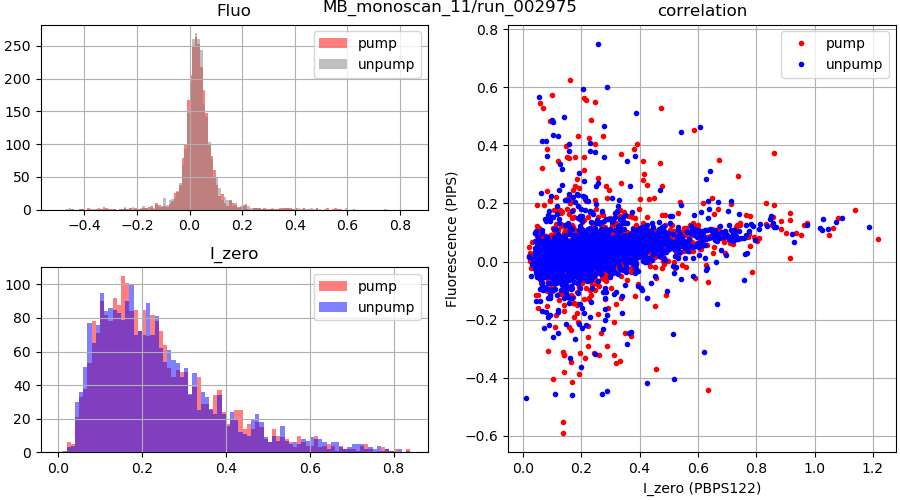

In [3]:
f ="run_002975.BSREAD.h5"
fn = DIR + f

channel_list_pp = [channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_energy]

resultsPP, results = load_data_compact_laser_pump(channel_list_pp, channel_list_all, fn)

#(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
# DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(fn, channel_energy)
Energy_shot = results[channel_energy]

IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

print ("Energy = {} eV".format(np.median(Energy_shot)))
print ("Median value Izero (all) = {}".format(np.median(np.concatenate((IzeroFEL_pump_raw, IzeroFEL_unpump_raw), axis=0))))
print ("Median value fluo (all) = {}".format(np.median(np.concatenate((DataFluo_pump_shot_raw, DataFluo_unpump_shot_raw), axis=0))))

fig = plt.figure(constrained_layout=True, figsize=(9,5))
plt.suptitle(scan_name +"/"+ f.split('.')[0], y = 1)
gs = fig.add_gridspec(2, 2)

f_ax1 = fig.add_subplot(gs[0, :-1])
f_ax1.set_title('Fluo')
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="pump", alpha=0.5)
plt.hist(DataFluo_unpump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='grey', label="unpump", alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax2 = fig.add_subplot(gs[1, :-1])
f_ax2.set_title('I_zero')
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label='pump', alpha=0.5)
plt.hist(IzeroFEL_unpump_shot, bins =np.arange(0,0.85,0.01), facecolor='blue', label ='unpump', alpha=0.5)
plt.grid()
plt.legend(loc="best")

f_ax3 = fig.add_subplot(gs[0:, 1])
f_ax3.set_title('correlation')
plt.plot(IzeroFEL_pump_shot, DataFluo_pump_shot, color = 'red',  linestyle='None', label='pump',marker='.')
plt.plot(IzeroFEL_unpump_shot, DataFluo_unpump_shot, color = 'blue',  linestyle='None', label='unpump',marker='.')
plt.grid()
plt.legend(loc="best")
plt.xlabel("I_zero (PBPS122)")
plt.ylabel ("Fluorescence (PIPS)")

plt.show()


### Then filter the same data

In [4]:
min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.5
########################################################################################################

ffn = DIR + f

channel_list_pp = [channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_energy]

resultsPP, results = load_data_compact_laser_pump(channel_list_pp, channel_list_all, fn)

#(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
# DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(ffn, channel_energy)

IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump

IzeroFEL_pump_raw = IzeroFEL_pump_shot.copy()
IzeroFEL_unpump_raw = IzeroFEL_unpump_shot.copy()
DataFluo_pump_shot_raw = DataFluo_pump_shot.copy()
DataFluo_unpump_shot_raw = DataFluo_unpump_shot.copy()

threshold_FEL_pump = IzeroFEL_pump_shot > min_I0
threshold_FEL_unpump = IzeroFEL_unpump_shot > min_I0
threshold_fluo_pump = DataFluo_pump_shot > min_fluo
threshold_fluo_unpump = DataFluo_unpump_shot > min_fluo

thresholds_filter = threshold_FEL_pump & threshold_FEL_unpump & \
                   threshold_fluo_pump & threshold_fluo_unpump

DataFluo_pump_shot = DataFluo_pump_shot[thresholds_filter]
DataFluo_unpump_shot = DataFluo_unpump_shot[thresholds_filter]
IzeroFEL_pump_shot = IzeroFEL_pump_shot[thresholds_filter]
IzeroFEL_unpump_shot = IzeroFEL_unpump_shot[thresholds_filter]

DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
DataFluo_pump_shot_norm_raw = DataFluo_pump_shot_norm.copy()

med = np.median(DataFluo_unpump_shot_norm)
qnt_low = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_unpump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_unpump_low = DataFluo_unpump_shot_norm > qnt_low
condition_corr_unpump_high = DataFluo_unpump_shot_norm < qnt_high

med = np.median(DataFluo_pump_shot_norm)
qnt_low = np.nanquantile(DataFluo_pump_shot_norm, 0.5 - quantile_corr/2)
qnt_high = np.nanquantile(DataFluo_pump_shot_norm, 0.5 + quantile_corr/2)

condition_corr_pump_low = DataFluo_pump_shot_norm > qnt_low
condition_corr_pump_high = DataFluo_pump_shot_norm < qnt_high

correlation_filter = condition_corr_unpump_low & condition_corr_unpump_high & \
                    condition_corr_pump_low & condition_corr_pump_high

DataFluo_pump_shot_norm = DataFluo_pump_shot_norm[correlation_filter]
DataFluo_unpump_shot_norm = DataFluo_unpump_shot_norm[correlation_filter]

print ("Original size (pump/umpump):", len(DataFluo_pump_shot_raw), len(DataFluo_unpump_shot_raw))
print ("Filtered size conditions (pump/unpump):", len(DataFluo_pump_shot), len(DataFluo_unpump_shot))
print ("Filtered size correlation (pump/unpump):", len(DataFluo_pump_shot_norm), len(DataFluo_unpump_shot_norm))
print ("Energy = {} eV".format(Energy_shot.mean()))
print ("Median value Izero (filter) = {}".format(np.median(IzeroFEL_pump_shot)))
print ("Median value fluo (filter) = {}".format(np.median(DataFluo_pump_shot_raw)))



--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 9999 / 9999 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Loaded pump = (2499,) and unpump = (2499,) shots
Original size (pump/umpump): 2499 2499
Filtered size conditions (pump/unpump): 1542 1542
Filtered size correlation (pump/unpump): 383 383
Energy = 1238.617057582632 eV
Median value Izero (filter) = 0.22519243508577347
Median value fluo (filter) = 0.029823831992574268


<IPython.core.display.Javascript object>


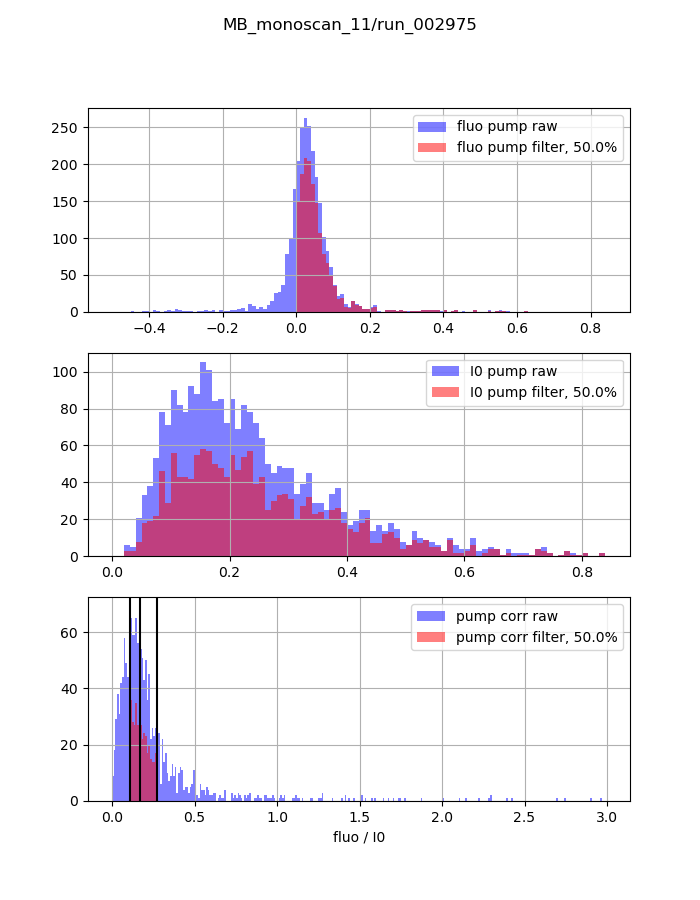

quantile range = 0.25 0.75


In [5]:
plt.figure(figsize = (7,9))
plt.suptitle(scan_name +"/"+ f.split('.')[0])

plt.subplot(311)
plt.hist(DataFluo_pump_shot_raw, bins =np.arange(-0.5,0.85,0.01), facecolor='blue', label="fluo pump raw", alpha=0.5)
plt.hist(DataFluo_pump_shot, bins =np.arange(-0.5,0.85,0.01), facecolor='red', label="fluo pump filter, {}%".format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(312)
plt.hist(IzeroFEL_pump_raw, bins =np.arange(0,0.85,0.01), facecolor='blue', label='I0 pump raw', alpha=0.5)
plt.hist(IzeroFEL_pump_shot, bins =np.arange(0,0.85,0.01), facecolor='red', label ='I0 pump filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")

plt.subplot(313)
x_axis = np.arange(0,3,0.01)
plt.hist(DataFluo_pump_shot_norm_raw, bins =x_axis, facecolor='blue', label='pump corr raw', alpha=0.5)
plt.hist(DataFluo_pump_shot_norm, bins =x_axis, facecolor='red', label='pump corr filter, {}%'.format(quantile_corr*100), alpha=0.5)
plt.grid()
plt.legend(loc="best")
plt.axvline(med, color = 'k') 
plt.axvline(qnt_low, color = 'k')
plt.axvline(qnt_high, color = 'k') 
plt.xlabel('fluo / I0')

plt.show()
print ('quantile range = {}'.format(0.5 - quantile_corr/2), 0.5 + quantile_corr/2)

# Now load the full scan

### First, without any filtering of the data, check data distributions with quantiles 

In [6]:
quantiles = [0.5, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9]

channel_list_pp = [channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_energy]

########################################################
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

Energy_eV = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        resultsPP, results = load_data_compact_laser_pump(channel_list_pp, channel_list_all, filename)
        
        #(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
        # DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(filename, channel_energy)
        
        Energy_shot = results[channel_energy]
        
        IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
        IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
        DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
        DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump
  
        print ("Loaded {} shots".format(len(DataFluo_pump_shot)))
    
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
              
        DataFluo_pump.append(np.nanquantile(df_pump, quantiles))
        DataFluo_unpump.append(np.nanquantile(df_unpump, quantiles))
        Pump_probe.append(np.nanquantile(df_pump_probe, quantiles))
        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.median(Energy_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)

Energy_eV = np.asarray(Energy_eV)

print ("Job done!")


step 46 of 46 : Processing /sf/alvra/data/p18442/raw/scan_data/MB_monoscan_11/run_002997.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 9999 / 9999 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Loaded pump = (2499,) and unpump = (2499,) shots
Loaded 2499 shots
Job done!


<IPython.core.display.Javascript object>


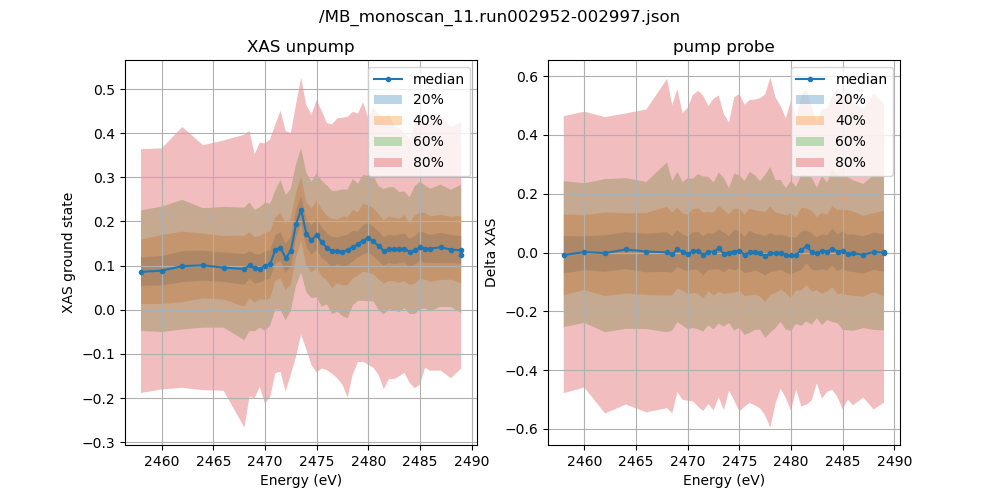

In [7]:
plt.figure(figsize = (10,5))
plt.suptitle(json_file.split('scan_info')[1], fontsize=12)

plt.subplot(1,2,1)
plt.plot(Energy_eV, DataFluo_unpump[:,0],label='median',marker='.' )
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,4]),np.array(DataFluo_unpump[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,3]),np.array(DataFluo_unpump[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,2]),np.array(DataFluo_unpump[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(DataFluo_unpump[:,1]),np.array(DataFluo_unpump[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('XAS unpump')
plt.legend(loc="best")
plt.ylabel("XAS ground state")
plt.xlabel("Energy (eV)")

plt.subplot(1,2,2)
plt.plot(Energy_eV, Pump_probe[:,0],label='median',marker='.' )
plt.fill_between(Energy_eV,np.array(Pump_probe[:,4]),np.array(Pump_probe[:,5]), label='20%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(Pump_probe[:,3]),np.array(Pump_probe[:,6]), label='40%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(Pump_probe[:,2]),np.array(Pump_probe[:,7]), label='60%', alpha = 0.3)
plt.fill_between(Energy_eV,np.array(Pump_probe[:,1]),np.array(Pump_probe[:,8]), label='80%', alpha = 0.3)
plt.grid()
plt.gca().set_title('pump probe')
plt.legend(loc="best")
plt.ylabel("Delta XAS")
plt.xlabel("Energy (eV)")

plt.show()

### Now choose thresholds and quantile

In [8]:
min_I0 = 0.01
min_fluo = 0.001
quantile_corr = 0.1

channel_list_pp = [channel_PIPS_fluo, channel_Izero122]
channel_list_all = channel_list_pp + [channel_energy]

########################################################################
json_file = DIR_json + scan_name + scan_range + ".json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 35

print ("Processing",numFiles,"files")

DataFluo_pump = []
DataFluo_unpump = []
err_DataFluo_pump = []
err_DataFluo_unpump = []

Pump_probe = []
err_Pump_probe = []

Energy_eV = []

for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: #and i!=0:
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" %(str(data['scan_files'][i][0])))
        
        resultsPP, results = load_data_compact_laser_pump(channel_list_pp, channel_list_all, filename)
        
        #(DataFluo_pump_shot, DataFluo_unpump_shot, IzeroFEL_pump_shot, IzeroFEL_unpump_shot, Energy_shot, \
        # DataTrans_pump_shot, DataTrans_unpump_shot, pids_shot) = load_PumpProbe_events(filename, channel_energy)
        
        Energy_shot = results[channel_energy]
        
        IzeroFEL_pump_shot = resultsPP[channel_Izero122].pump
        IzeroFEL_unpump_shot = resultsPP[channel_Izero122].unpump
        DataFluo_pump_shot = resultsPP[channel_PIPS_fluo].pump
        DataFluo_unpump_shot = resultsPP[channel_PIPS_fluo].unpump
        
        print ("Loaded {} shots".format(len(DataFluo_pump_shot)))
        
        DataFluo_pump_shot_norm = DataFluo_pump_shot / IzeroFEL_pump_shot
        DataFluo_unpump_shot_norm = DataFluo_unpump_shot / IzeroFEL_unpump_shot
        Pump_probe_shot = DataFluo_pump_shot_norm - DataFluo_unpump_shot_norm
        
        df_pump = pd.DataFrame(DataFluo_pump_shot_norm)
        df_unpump = pd.DataFrame(DataFluo_unpump_shot_norm)
        df_pump_probe = pd.DataFrame(Pump_probe_shot)
        
        DataFluo_pump.append(np.nanquantile(df_pump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        DataFluo_unpump.append(np.nanquantile(df_unpump, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile_corr/2, 0.5 + quantile_corr/2]))
        
        Energy_shot = [x for x in Energy_shot if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(Energy_shot))
    
DataFluo_pump = np.asarray(DataFluo_pump)
DataFluo_unpump = np.asarray(DataFluo_unpump)
Pump_probe = np.asarray(Pump_probe)
                  
Energy_eV = np.asarray(Energy_eV)

print ("Job done!")


step 46 of 46 : Processing /sf/alvra/data/p18442/raw/scan_data/MB_monoscan_11/run_002997.BSREAD.h5

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet   9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH2_VAL_GET  9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS122:INTENSITY 9999 / 9999 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 9999 / 9999 -> 0% loss

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 50.0 Hz
Loaded pump = (2499,) and unpump = (2499,) shots
Loaded 2499 shots
Job done!


# Plot energy scans

<IPython.core.display.Javascript object>


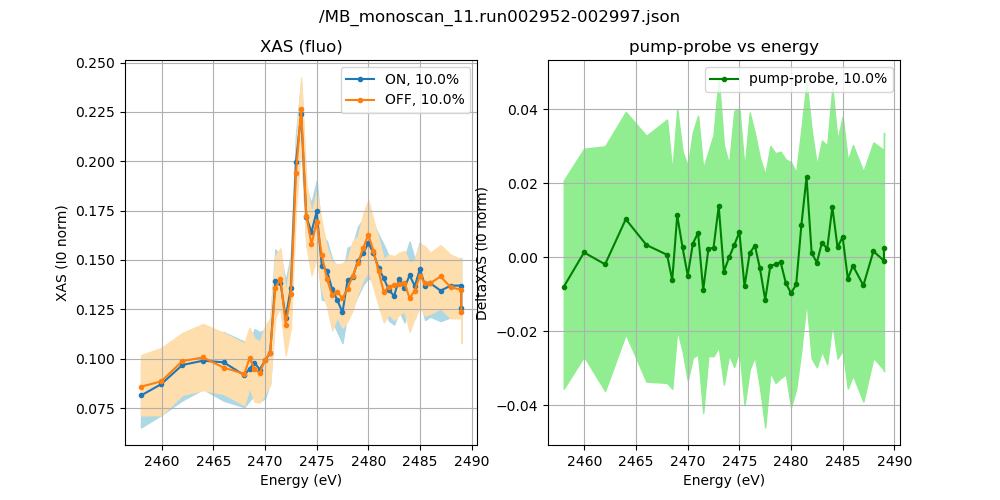

In [9]:
plt.figure(figsize = (10,5))
plt.suptitle(json_file.split('scan_info')[1], fontsize=12)

Pump_probe_relative = (DataFluo_pump - DataFluo_unpump) / DataFluo_unpump
XAS_pump = DataFluo_pump[:,0]
err_low_pump = DataFluo_pump[:,1]
err_high_pump = DataFluo_pump[:,2]
XAS_unpump = DataFluo_unpump[:,0]
err_low_unpump = DataFluo_unpump[:,1]
err_high_unpump = DataFluo_unpump[:,2]
XAS_pump_probe = Pump_probe[:,0]
err_low_pump_probe = Pump_probe[:,1]
err_high_pump_probe = Pump_probe[:,2]

plt.subplot(1,2,1)
plt.plot(Energy_eV, XAS_pump, label='ON, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV, err_low_pump, err_high_pump, color='lightblue')

plt.plot(Energy_eV, XAS_unpump, label='OFF, {}%'.format(quantile_corr*100),marker='.')
plt.fill_between(Energy_eV, err_low_unpump, err_high_unpump, color='navajowhite')

plt.xlabel("Energy (eV)")
plt.ylabel ("XAS (I0 norm)")
plt.gca().set_title('XAS (fluo)')
plt.legend(loc="best")
plt.grid()

plt.subplot(1,2,2)
plt.plot(Energy_eV, XAS_pump_probe, label='pump-probe, {}%'.format(quantile_corr*100),color='green', marker='.')
plt.fill_between(Energy_eV,err_low_pump_probe, err_high_pump_probe, color='lightgreen')
plt.xlabel("Energy (eV)")
plt.ylabel ("DeltaXAS (I0 norm)")
plt.gca().set_title('pump-probe vs energy')
plt.legend(loc="best")
plt.grid()

plt.show()



## cell to export data

In [ ]:
import pandas as pd
DIR_save = "/das/work/p17/p17589/Extract_data_MbNo/"
file2save = DIR_save + scan_name + ".txt"
pd.DataFrame({
    'pump_probe': Pump_probe_15uJ,
    'signal_on' : DataFluo_pump_15uJ,
    'signal_off' : DataFluo_unpump_15uJ,
}).to_csv(file2save,index=False)